In [1]:
import tensorflow as tf
import re

import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation, Dense, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
tf.__version__

'2.1.0'

In [35]:
import jieba
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('ggplot')  
plt.rcParams['font.family']='Microsoft YaHei'
plt.rcParams['axes.unicode_minus']= False

# 读取数据

In [96]:
xtrain = pd.read_csv('警情记录-train.csv',encoding='gbk')
xtrain.head()

,报警人性别,报警内容,出警情况,反馈警情类别
0,男,事故后期，赔偿纠纷,2019年7月27日9时41分许，民警***带领辅警冯诚军，***到达萧山区靖江路与广场路西...,求助
1,男,称因感情问题，妹妹扬言要自杀 已通知120,民警***带领辅警**、***、**到达二桥村327号报警现场，经了解报警人***（男：19...,求助
2,男,装修噪音扰民,民警来*到达湘湖家园78-3-601，据报警人（未透露身份信息）称有装修工噪音扰民，现场装修...,求助
3,男,"称中暑了 120\n重复报警:报警时间:2019-07-27 09:29:40, 报警电话...",民警***到达瓜沥镇**娄观音庙后面，经调查，系报警人于2019年7月27日9时16分因中暑...,求助
4,男,电梯里的广告牌被人损坏,2019年7月27日8时58分许，民警***带领辅警冯诚军，***到达萧山区靖江街道靖东村村...,求助


In [97]:
xtrain.columns = ['age','content','alert','label']

In [98]:
xtest = pd.read_csv('警情记录-test.csv',encoding='gbk')
xtest.head()

,报警人性别,报警内容,出警情况（反馈内容）,最终反馈警情类别
0,男,称有人喝醉酒躺在路边，120,民警**出警途中接报警人电话称酒醉人员已经回到湘湖逍遥庄园工地里面，无需民警过去救助。（报警...,求助
1,男,路人报警称路边有各女孩子一直在哭,民警***到达瓜沥镇航民文化中心，经调查，系一女孩（不愿登记身份信息）因琐事于2019年7月...,求助
2,男,"捡到一张身份证\n重复报警:报警时间:2019-07-31 23:34:41, 报警电话:1...",民警***带辅警** *** ***到达二桥村水浒饭店现场：系报警人(*** 男 1997*...,求助
3,男,称两台空调被偷,"民警***到达瓜沥镇人民路1330号，经调查，系***（1974********,158**...",求助
4,男,称手机遗失，求助,民警任水灿电话联系报警人***（1971********）称其手机遗失，求助查看加油站监控，...,求助


In [99]:
xtest.columns = ['age','content','alert','label']

# 标签编码

In [100]:
moods = { '纠纷':0, '求助':1, '治安案件':2, '其它报警':3,'刑事案件':4,'举报':5} 
xtrain['label'] = xtrain['label'].replace(moods)
xtest['label'] = xtest['label'].replace(moods)  
xtrain.head()

,age,content,alert,label
0,男,事故后期，赔偿纠纷,2019年7月27日9时41分许，民警***带领辅警冯诚军，***到达萧山区靖江路与广场路西...,1
1,男,称因感情问题，妹妹扬言要自杀 已通知120,民警***带领辅警**、***、**到达二桥村327号报警现场，经了解报警人***（男：19...,1
2,男,装修噪音扰民,民警来*到达湘湖家园78-3-601，据报警人（未透露身份信息）称有装修工噪音扰民，现场装修...,1
3,男,"称中暑了 120\n重复报警:报警时间:2019-07-27 09:29:40, 报警电话...",民警***到达瓜沥镇**娄观音庙后面，经调查，系报警人于2019年7月27日9时16分因中暑...,1
4,男,电梯里的广告牌被人损坏,2019年7月27日8时58分许，民警***带领辅警冯诚军，***到达萧山区靖江街道靖东村村...,1


# 统计个数

In [101]:
xtrain['label'].value_counts()

0    2841
1    1220
2    1123
3    1043
4     427
5     174
Name: label, dtype: int64

In [102]:
moods = {0: '纠纷', 1: '求助',2: '治安案件',3: '其它报警',4: '刑事案件',5: '举报'} 

print('评论数目（总体）：%d' % xtrain.shape[0])

for label, mood in moods.items(): 
    print('评论数目（{}）：{}'.format(mood,  xtrain[xtrain.label==label].shape[0]))

评论数目（总体）：6828
评论数目（纠纷）：2841
评论数目（求助）：1220
评论数目（治安案件）：1123
评论数目（其它报警）：1043
评论数目（刑事案件）：427
评论数目（举报）：174


In [103]:
xtrain['reviews'] = xtrain['age'].astype(str) + xtrain['content'].astype(str) + xtrain['alert'].astype(str)
xtest['reviews'] = xtest['age'].astype(str) + xtest['content'].astype(str) + xtest['alert'].astype(str)
xtrain = xtrain[['label','reviews']]
xtest = xtest[['label','reviews']]

In [104]:
xtrain

,label,reviews
0,1,男事故后期，赔偿纠纷2019年7月27日9时41分许，民警***带领辅警冯诚军，***到达萧...
1,1,男称因感情问题，妹妹扬言要自杀 已通知120民警***带领辅警**、***、**到达二桥村...
2,1,男装修噪音扰民民警来*到达湘湖家园78-3-601，据报警人（未透露身份信息）称有装修工噪音...
3,1,"男称中暑了 120\n重复报警:报警时间:2019-07-27 09:29:40, 报警电..."
4,1,男电梯里的广告牌被人损坏2019年7月27日8时58分许，民警***带领辅警冯诚军，***到...
...,...,...
6823,4,男电缆线被偷进化派出所民警到达现场，系***（男，1971********）报警称：2019...
6824,4,男报警人称办信用卡被骗几百元，明天会自行到所报案民警谢少科电话联系报警人，报警人***（男，...
6825,4,"女昨天放吧台上包里的1万元不见了2019年7月1日10时37分接***（女,, 年龄:49,..."
6826,4,男工地材料被偷 2019年7月1日早上报警人苗淼1982********称，2019年6月3...


In [106]:
xtest

,label,reviews
0,1,男称有人喝醉酒躺在路边，120民警**出警途中接报警人电话称酒醉人员已经回到湘湖逍遥庄园工地...
1,1,男路人报警称路边有各女孩子一直在哭民警***到达瓜沥镇航民文化中心，经调查，系一女孩（不愿登...
2,1,"男捡到一张身份证\n重复报警:报警时间:2019-07-31 23:34:41, 报警电话:..."
3,1,男称两台空调被偷民警***到达瓜沥镇人民路1330号，经调查，系***（1974******...
4,1,男称手机遗失，求助民警任水灿电话联系报警人***（1971********）称其手机遗失，求...
...,...,...
1361,4,男报警人称家里进贼了，现在不方便过去，请先电话联系。2019年7月28日2时12分许，民警*...
1362,4,男称有个人喝多了睡在马路边上民警**到达城厢崇化路上，经了解，系路人***（男 1999*...
1363,4,男淘宝上钱被骗报警人***1996********自行来所反映，在其淘宝上帮人代买东西，对方...
1364,4,男称放家里的钱包被偷，546029民警***到达霞江村菜场旁边，经了解和现场查看，报警人**...


In [107]:
# xtest.to_excel('测试集预处理数据.xlsx',index=0)

In [108]:
# 数据过滤
def regex_filter(s_line):
    # 剔除英文、数字，以及空格
    special_regex = re.compile(r"[a-zA-Z0-9\s]+")
    # 剔除英文标点符号和特殊符号
    en_regex = re.compile(r"[.…{|}#$%&\'()*+,!-_./:~^;<=>?@★●，。]+")
    # 剔除中文标点符号
    zn_regex = re.compile(r"[《》！、，“”；：（）【】]+")

    s_line = special_regex.sub(r"", s_line)
    s_line = en_regex.sub(r"", s_line)
    s_line = zn_regex.sub(r"", s_line)
    return s_line

In [109]:
# 加载停用词
def stopwords_list(file_path):
    stopwords = [line.strip() for line in open(file_path, 'r', encoding='utf-8').readlines()]
    return stopwords

In [110]:
import collections
word_freqs = collections.Counter()
stopword = stopwords_list("stopwords.txt")
max_len = 0

In [111]:
# 分词去停用词
for sentence in xtrain["reviews"].tolist():
    sentence = regex_filter(str(sentence))
    words = jieba.cut(sentence)
    x = 0
    for word in words:
        if word not in stopword:
            word_freqs[word] += 1
            x += 1
    max_len = max(max_len, x)
print(max_len)
print('nb_words ', len(word_freqs))

241
nb_words  20742


In [112]:
MAX_FEATURES = 12000 # 最大词频数
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
# 构建词频字典
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
# 将词频字典写入文件中保存
with open('word_dict.pickle', 'wb') as handle:
    pickle.dump(word2index, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [113]:
# 加载分词字典
with open('word_dict.pickle', 'rb') as handle:
    word2index = pickle.load(handle)

In [114]:
### 准备数据
MAX_FEATURES = 12002 # 最大词频数
MAX_SENTENCE_LENGTH = 160 # 句子最大长度
num_recs = xtrain.shape[0]  # 样本数

# 初始化句子数组和label数组
X = np.empty(num_recs,dtype=list)
y = np.zeros(num_recs)
i=0

In [115]:
# 训练集每个样本在词频字典中的向量矩阵
for label, sentence in zip(xtrain["label"].tolist(), xtrain["reviews"].tolist()):
    words = jieba.cut(sentence)
    seqs = []
    for word in words:
        # 在词频中
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    y[i] = int(label)
    i += 1


X1 = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

y1 = pd.get_dummies(y).values
print(X1.shape)
print(y1.shape)

(6828, 160)
(6828, 6)


In [116]:
from tensorflow.keras import layers

In [126]:
embeddings_dim = 256
filters = 64
kernel_size = 5
batch_size = 64
maxlen = 160
# 搭建卷积神经网络层
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=maxlen))
model.add(layers.Conv1D(filters=filters,kernel_size=kernel_size,activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.3))
# 上面 GlobalMaxPool1D 后，维度少了一维，下面自定义layers再扩展一维
model.add(layers.Lambda(lambda x : tf.keras.backend.expand_dims(x, axis=-1)))
model.add(layers.Conv1D(filters=filters,kernel_size=kernel_size,activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6, activation='softmax')) #  多分类 softmax

In [127]:
# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 160, 256)          3072512   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 156, 64)           81984     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 64, 1)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 60, 64)            384       
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)               

In [128]:
# 数据划分-训练和验证
Xtrain, Xval, ytrain, yval = train_test_split(X1, y1, test_size=0.2, random_state=42,shuffle=True)

In [129]:
## 训练模型
history = model.fit(Xtrain, ytrain, batch_size=8, epochs=10,validation_data=(Xval, yval))

Train on 5462 samples, validate on 1366 samples
Epoch 1/10
5462/5462 [==============================] - 24s 4ms/sample - loss: 0.3483 - accuracy: 0.8650 - val_loss: 0.3256 - val_accuracy: 0.8792
Epoch 2/10
5462/5462 [==============================] - 20s 4ms/sample - loss: 0.2979 - accuracy: 0.8826 - val_loss: 0.2931 - val_accuracy: 0.8827
Epoch 3/10
5462/5462 [==============================] - 20s 4ms/sample - loss: 0.2645 - accuracy: 0.8940 - val_loss: 0.2629 - val_accuracy: 0.8959
Epoch 4/10
5462/5462 [==============================] - 20s 4ms/sample - loss: 0.2356 - accuracy: 0.9021 - val_loss: 0.2769 - val_accuracy: 0.8954
Epoch 5/10
5462/5462 [==============================] - 20s 4ms/sample - loss: 0.2121 - accuracy: 0.9100 - val_loss: 0.2837 - val_accuracy: 0.8904
Epoch 6/10
5462/5462 [==============================] - 20s 4ms/sample - loss: 0.1960 - accuracy: 0.9164 - val_loss: 0.2587 - val_accuracy: 0.8979
Epoch 7/10
5462/5462 [==============================] - 20s 4ms/sample

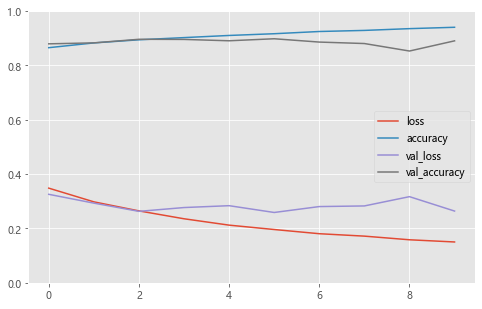

In [130]:
# 绘制训练曲线
from matplotlib import pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [131]:
# 测试集评估模型
import collections
word_freqs = collections.Counter()
stopword = stopwords_list("stopwords.txt")
max_len = 0

In [132]:
# 分词去停用词
for sentence in xtest["reviews"].tolist():
    sentence = regex_filter(str(sentence))
    words = jieba.cut(sentence)
    x = 0
    for word in words:
        if word not in stopword:
            word_freqs[word] += 1
            x += 1
    max_len = max(max_len, x)
print(max_len)
print('nb_words ', len(word_freqs))

183
nb_words  8123


In [133]:
MAX_FEATURES = 12000 # 最大词频数
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
# 构建词频字典
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
# 将词频字典写入文件中保存
with open('word_dict.pickle', 'wb') as handle:
    pickle.dump(word2index, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [134]:
# 加载分词字典
with open('word_dict.pickle', 'rb') as handle:
    word2index = pickle.load(handle)

In [135]:
### 准备数据
MAX_FEATURES = 12002 # 最大词频数
MAX_SENTENCE_LENGTH = 160 # 句子最大长度
num_recs = xtest.shape[0]  # 样本数

# 初始化句子数组和label数组
X = np.empty(num_recs,dtype=list)
y = np.zeros(num_recs)
i=0

In [136]:
# 训练集每个样本在词频字典中的向量矩阵
for label, sentence in zip(xtest["label"].tolist(), xtest["reviews"].tolist()):
    words = jieba.cut(sentence)
    seqs = []
    for word in words:
        # 在词频中
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    y[i] = int(label)
    i += 1


Xtest = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

ytest = pd.get_dummies(y).values
print(Xtest.shape)
print(Xtest.shape)

(1366, 160)
(1366, 160)


In [138]:
## 验证集评估模型
y_pred = model.predict(Xval)
y_pred = y_pred.argmax(axis=1)
yval = yval.argmax(axis=1)

print('accuracy %s' % accuracy_score(y_pred, yval))
target_names = ['纠纷', '求助', '治安案件', '其它报警', '刑事案件','举报']
print(classification_report(yval, y_pred, target_names=target_names))

accuracy 0.6456808199121523
              precision    recall  f1-score   support

          纠纷       0.89      0.75      0.81       548
          求助       0.74      0.76      0.75       260
        治安案件       0.54      0.51      0.53       223
        其它报警       0.34      0.43      0.38       211
        刑事案件       0.44      0.79      0.56        89
          举报       0.00      0.00      0.00        35

    accuracy                           0.65      1366
   macro avg       0.49      0.54      0.50      1366
weighted avg       0.67      0.65      0.65      1366



In [137]:
## 测试集评估模型
y_pred = model.predict(Xtest)
y_pred = y_pred.argmax(axis=1)
ytest = ytest.argmax(axis=1)

print('accuracy %s' % accuracy_score(y_pred, ytest))
target_names = ['纠纷', '求助', '治安案件', '其它报警', '刑事案件','举报']
print(classification_report(ytest, y_pred, target_names=target_names))

accuracy 0.15739385065885797
              precision    recall  f1-score   support

          纠纷       0.36      0.07      0.12       568
          求助       0.13      0.18      0.15       244
        治安案件       0.13      0.10      0.11       225
        其它报警       0.15      0.50      0.23       209
        刑事案件       0.05      0.02      0.03        85
          举报       0.00      0.00      0.00        35

    accuracy                           0.16      1366
   macro avg       0.14      0.15      0.11      1366
weighted avg       0.22      0.16      0.13      1366

